<a id="top_section"></a>
# Introduction

When I started doing this analysis my main goal was getting experience. I'm still learning and trying to improve my skills, so there might be some areas can be improved.


### My main objectives on this project are:

* Explorating and visualising the data, trying to get some insights about our dataset,
* Getting data in better shape by feature engineering to help us in building better models,
* Building and tuning couple classification models to get some stable results on predicting Titanic disaster outcome.

### In this notebook we are going to try explore the data we have and going try answer questions like:

- What is the survival rate for specific groups?
- Is there any relation between given info of passengers and their survival?
- Was women and children first policy in order?
- Having higher social status in helped people getting in life boats?
- The mustering order from captain was highly dependent on the class of the passengers, can we spot this  effect between pclass and the survival rates?
- What are the effects of being alone or with family?

- Can we predict if a passenger survived from the disaster with using machine learning techniques?
- What can our predictions achieve with different approaches?
- How are the ROC and Learning curves looks like for different models and can they help with selecting right one?
- If we decrease dimensionality by feature selection and extraction, what would be the effects on the models?
- How are the decision regions looks like for different estimators?



#### If you liked this kernel feel free to upvote and leave feedback, thanks!


<a id="toc_section"></a>
## Table of Contents
* [Introduction](#top_section)
    - [Well... What do we have here?](#section1)
* [Exploring the Data](#section2)
    - [Categorical Features](#section3)
    - [Numerical Features](#section4)
    - [Missing Values](#section5)    
* [Feature Engineering](#section6)
    - [Summary](#section7)
    - [Add new features](#section8)
    - [Ordinal Encoding](#section9)   
    - [Discard all unnecessary Features](#section10)
    - [Age IterativeImputer
](#section11)
* [Double Check](#section12)
    - [Correlation Matrix](#section13)
* [Modelling](#section14)
    - [baseline Model](#section15)
    - [Voting Classifier](#section16)
    - [Model Tuning](#section17)
    - [ROC'S of the Models](#section18)
    - [Learning Curves of the Models](#section19)
* [Dimensionality Reduction with Neighborhood Components Analysis](#section20)
* [Plotting Decision Boundaries](#section21)
* [Plotting Decision Regions](#section22)
* [Submission](#section23)


In [1]:
import pandas as pd
import numpy as np

# Plotting libreries
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px 

#

import warnings
warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs.
pd.options.display.max_columns = 50 # Pandas option to increase max number of columns to display.
plt.style.use('ggplot') # Setting default plot style.

# store python built-in global variable to later substract from my global variable
#python_data = set(globals())

<a id="section1"></a>
# Well... What do we have here?

Ok we have two sets(train and test) data and in total 1301 observations 11 features. Our target is Survived column which is not present on the test set(duh!)... 

I'm also saving idx variable for future use.

### [Back To Table of Contents](#toc_section)

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# display train data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Merging visualization datasets.

train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

df = pd.concat([train, test]).reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


<a id="section2"></a>
# Exploring the Data

<a id="section3"></a>
## Categorical Features

- **Survived:** Indicates that if particular passenger survived(1) or not(0)
- **Pclass:** Shows classes for the passenger, 1 for first, 2 for second and 3 for third.
- **Sex:** Indicates gender of the passenger. Might be crucial indicator for our model since historical records show women were first to save in ship accidents.
- **SibSp:** The number of siblings and spouses on the ship, might be useful for extracting family ties.
- **Parch:** The number of parents and children on the ship, migt have similar use with SibSp.
- **Embarked:** Flag for the where the passenger embarked from, C for Cherbourg, Q for Queenstown, S for Southampton

### [Back To Table of Contents](#toc_section)

In [4]:
a = train[['Survived', 'Sex', 'Pclass', 'SibSp', 'Age']].dropna()
a['Pclass']= a['Pclass'].map({1:'1 Pclass',2:'2 Pclass',3:'3 Pclass'})
a['Survived'] = a['Survived'].map({1:'Survived',0: 'Not Survived'})
a['SibSp']= a['SibSp'].map(lambda x: str(x)+' SibSp')


fig = px.sunburst(a, path=['Survived','Sex', 'Pclass','SibSp'], 
                  color='Age') 

fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))
fig.show()
del a

In [5]:

def plotFrequency(cats):
    '''A plot for visualize categorical data, showing both absolute and relative frequencies'''
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for ax, cat in zip(axes, cats):
        if cat == 'Survived':
            total = float(len(train[cat]))
        else:
            total = float(len(df[cat]))
        sns.countplot(df[cat], palette='plasma', ax=ax)

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

        plt.ylabel('Count', fontsize=15, weight='bold')

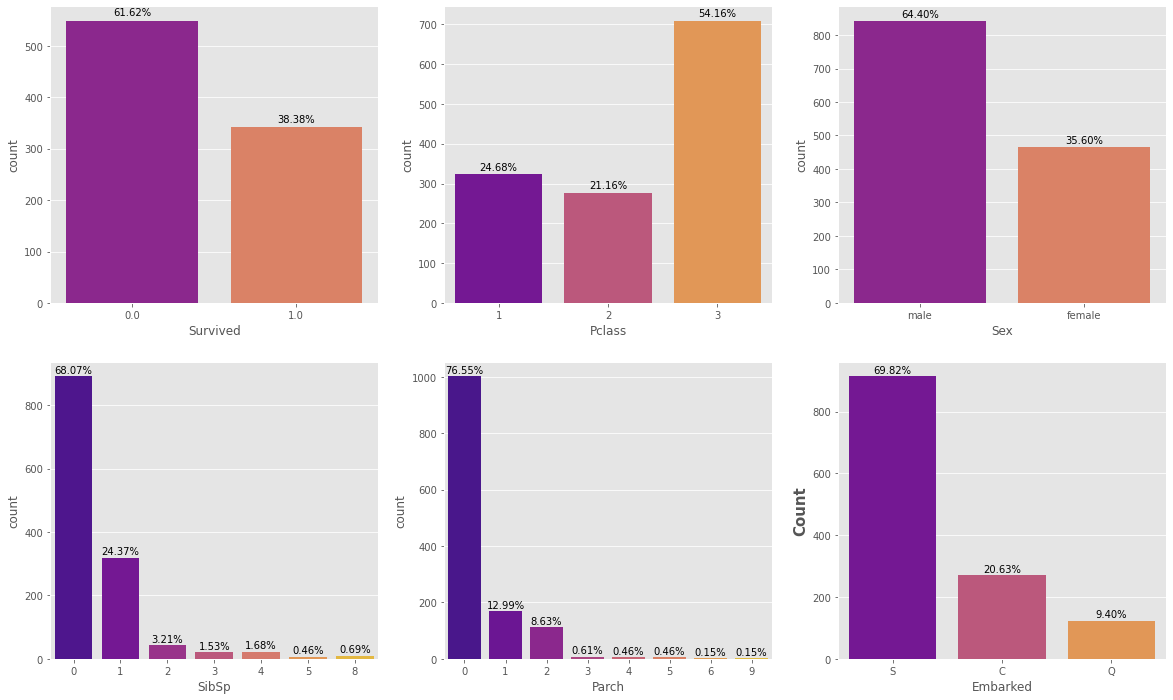

In [6]:
# Selecting categorical data for univariate analysis:
cats = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
plotFrequency(cats)

**Observations:**

Sadly most of the train set passengers are not survived, around 62 percent.
While having highest portion of the passengers on the ship, 3rd class also having highest casuality ratio. Meanwhile first class have more survival rate. So this kinda confirms our hypothesis that mustering orders from captain (1>2>3) might have effect on survival.
Again most of the passengers on the ship are males(around two third of the passengers) they also have much higher ratio of casualities too. This confirms women part of the "Women and children first policy" had an effect in our Titanic case.
Most of our passengers are travelling alone, they also have high casuality rate. So being married or with family has some positive effect on survival?
Most of the passenger are embarked from Southampton. Survival rates differ between ports but I'm not sure if it's important observation or just random. We can relate this to families, groups to get something out of it or just use as it is.

### [Back To Table of Contents](#toc_section)

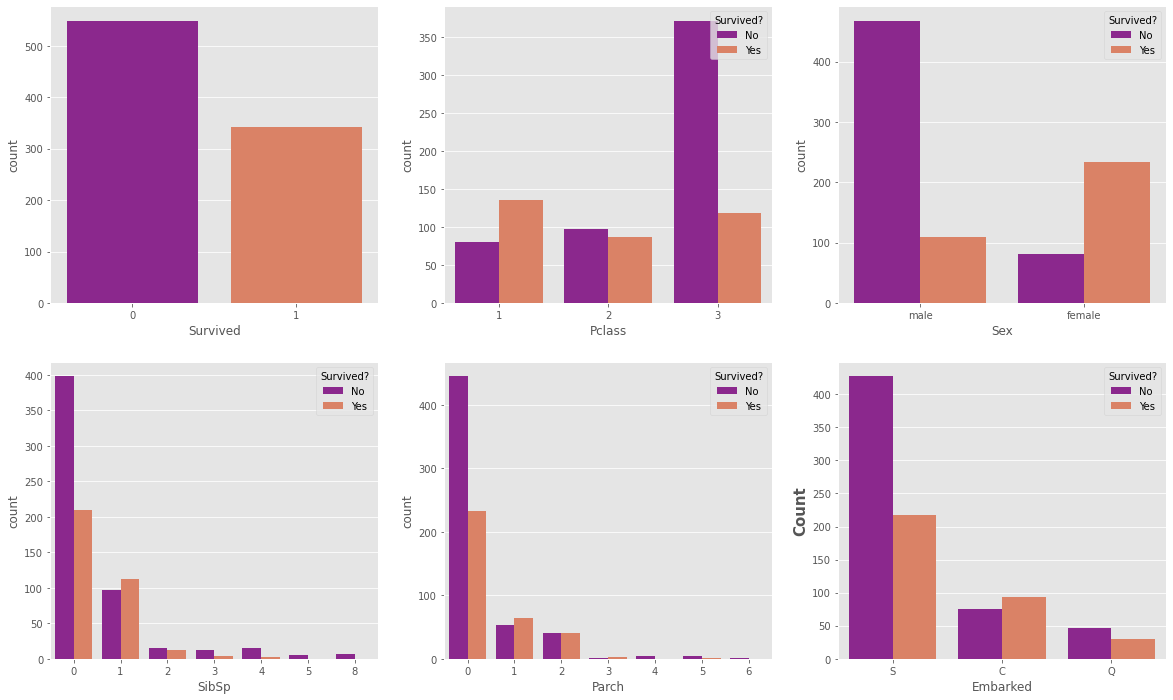

In [7]:
def plotsurvival(cats, data):
    
    '''A plot for bivariate analysis.'''
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for ax, cat in zip(axes, cats):
        if cat == 'Survived':
            sns.countplot(train[cat], palette='plasma', ax=ax)
        else:
            sns.countplot(x=cat,
                          data=data,
                          hue='Survived',
                          palette='plasma',
                          ax=ax)
            ax.legend(title='Survived?',
                      loc='upper right',
                      labels=['No', 'Yes'])

        plt.ylabel('Count', fontsize=15, weight='bold')

plotsurvival(cats, train)

# Name/Title
Finally, we could see if a person's title (Mr, Miss etc.) plays a role in survival. used Ken's [code](https://www.kaggle.com/code/konstantinmasich/titanic-0-82-0-83) to extract the title for each instance, then I replaced rare titles with more common ones.


**Observation**
* We have already talked about the fact that women (Mrs or Miss) had higher odds of survival. What's really interesting is that Masters and people with a Rare Title have indeed a higher chance of survival compared to 'common' men (Mr).

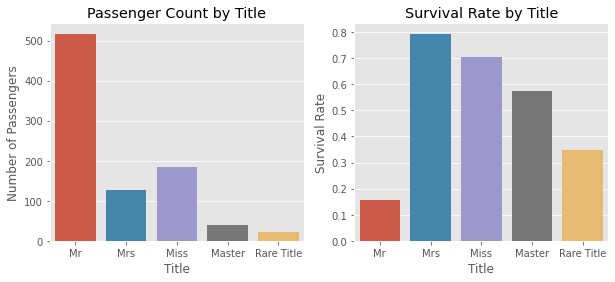

In [8]:
a = train.copy()
a['Title'] = a['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

a['Title'].replace({'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'}, inplace = True)
a['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer'],
                           'Rare Title', inplace = True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

sns.countplot(x = 'Title', data = a,  ax = ax1)
ax1.set_title('Passenger Count by Title')
ax1.set_ylabel('Number of Passengers')

sns.barplot(x = 'Title', y = 'Survived', data = a, ci = None, ax = ax2)
ax2.set_title('Survival Rate by Title')
ax2.set_ylabel('Survival Rate');

del a

<a id="section4"></a>
# Numerical Features
* **Age:** Well an obvious feature that indicates age of the passenger.
* **Fare:** Again obvious one that shows amount of the money spent on the ticket.
### Observations:

* Seems our Age values distrubuted well, little right skewed with high number of young adults. With the median age of 28 there are little bit of ouliers but things look ordinal.

* Fare distrubution doesn't look good, not fitting normal distrubution at all. While most of the passenger fares are below 30, there are some crazy outliers lying there like 500+ spent on tickets. We might need to scale our data for the models or assigning bins to categorize them to get better results...

### [Back To Table of Contents](#toc_section)

In [9]:
def plot_2chart(df, feature):
    import matplotlib.gridspec as gridspec
    from scipy.stats import norm
    # Creating a customized chart. and giving in figsize and everything.
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize= (20,8))
    
    ax1.set_title('Histogram')
    
    sns.distplot(df[feature],
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=ax1,
                 color='peru')
    
    ax2.set_title('Box-Plot')
    
    #plot boxplot
    sns.boxplot(df[feature],
                ax= ax2,
                color='peru')
    
    plt.suptitle(f'{feature}',fontsize=24)
        

    
    

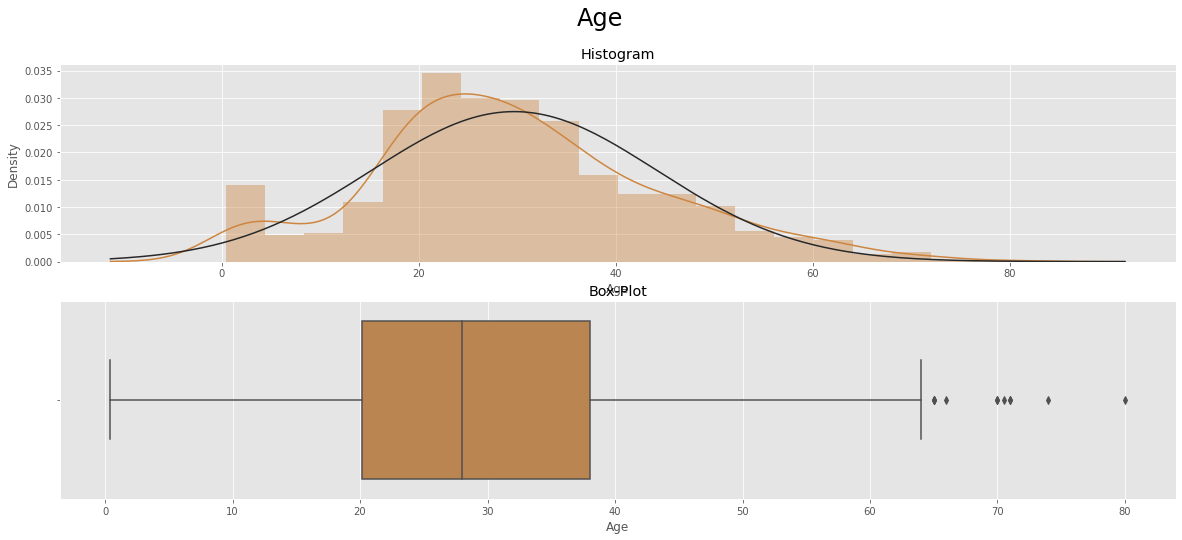

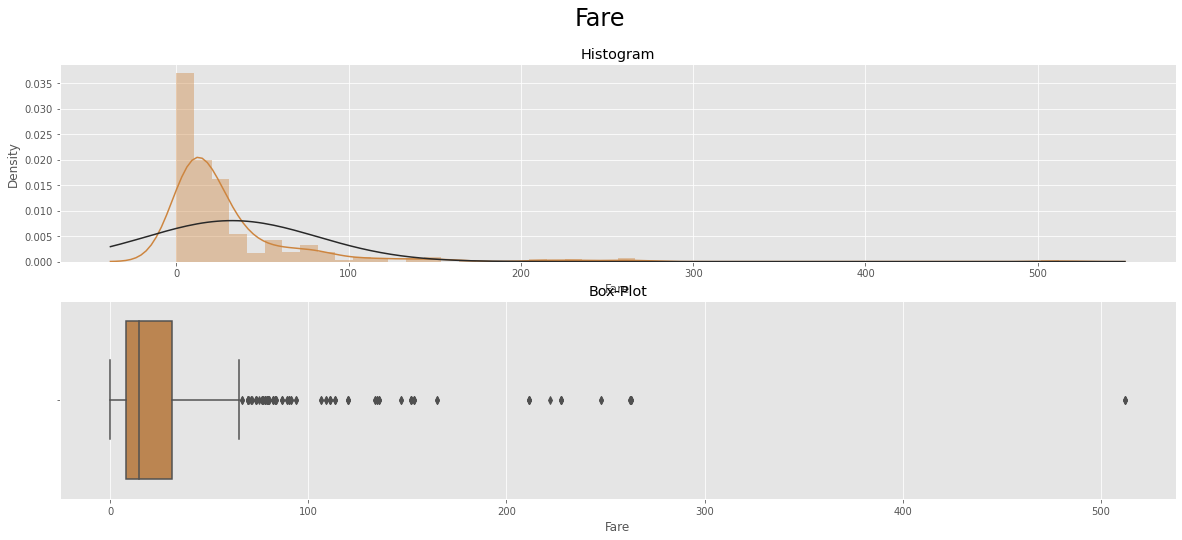

In [10]:
plot_2chart(train, 'Age')
plot_2chart(train, 'Fare')

## Age

This graph below gives a summary of the age range of men, women and children who were saved. The survival rate is
* **Good for children.**
* **High for women in the age range 20-50.**
* **Less for men as the age increases.**

Since Age column is important, the missing values need to be filled, either by using the Name column(ascertaining age based on salutation – Mr, Mrs etc.) or by using a regressor.

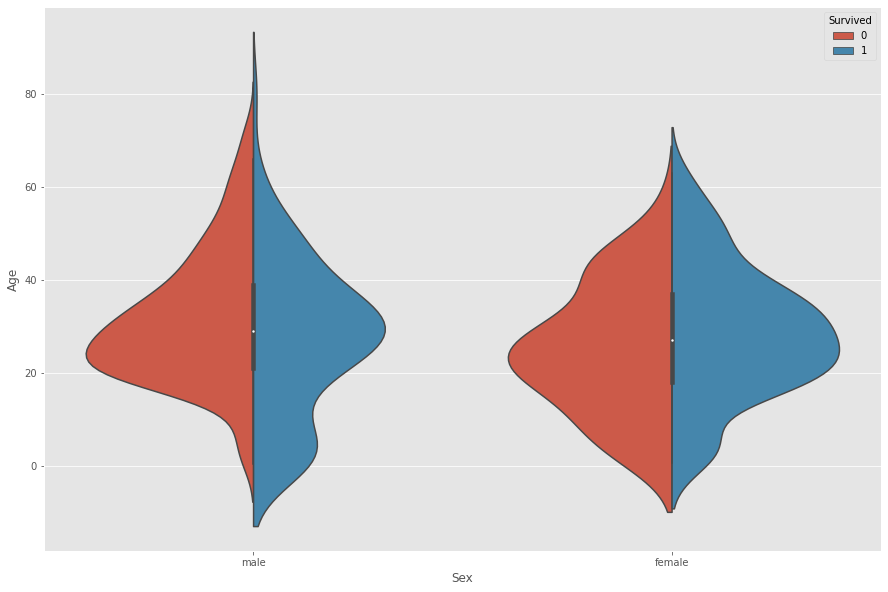

In [11]:
# Violinplot Displays distribution of data 
# across all levels of a category.
plt.figure(figsize=(15,10))
sns.violinplot(x ="Sex", y ="Age", hue ="Survived", 
               data = train, split = True)
plt.show()

# Fare
One would assume that fare is closely related to class. Let's plot a boxplot for the distribution of Fare values across classes and a Bar plot of Fare to survival chance:

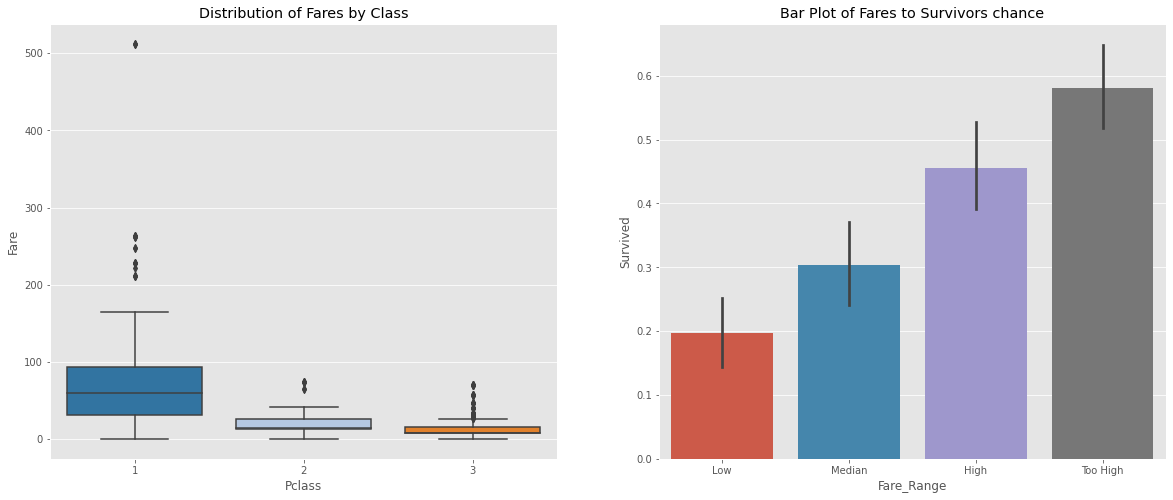

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

sns.boxplot(x = 'Pclass', y = 'Fare', data = train, palette = 'tab20', ax = ax1)
ax1.set_title('Distribution of Fares by Class')


a = train.copy()

# Divide Fare into 4 bins
a['Fare_Range'] = pd.qcut(train['Fare'], 4, labels= ['Low', 'Median', 'High', 'Too High'] )

sns.barplot(x='Fare_Range', y='Survived', data=a, ax=ax2)
ax2.set_title('Bar Plot of Fares to Survivors chance')

del a

<a id="section5"></a>
# Missing Values
On both datasets Cabin feature is missing a lot, it looks this feature not useful for modelling but we might give it a chance with feature engineering later.

Again, Age feature has many missing values, we can impute them with some logical way to use later...

There are little number of missing values on Embarked and Fare, I think we can impute them without taking much risk.

### [Back To Table of Contents](#toc_section)

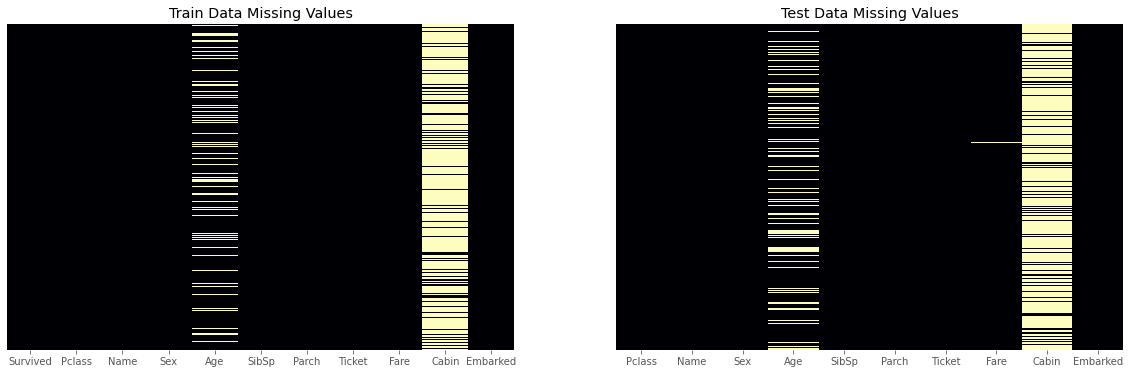

In [13]:
# Detecting missing data:

fig, axis = plt.subplots(1,2, figsize=(20,6))


for f, ax in zip([train, test], axis):
    sns.heatmap(f.isnull(),
            cbar=False,
            cmap='magma',
            yticklabels=False,
            ax=ax)

axis[0].set_title('Train Data Missing Values')
axis[1].set_title('Test Data Missing Values')
fig.show()

<a id="section6"></a>
# Feature Engineering

In this section, we will prepare the dataframe before we build any machine learning algorithm. We will use the combined dataframe so that both the train and the test set get processed at the same time. Another alternative would be to use pipilines.

### [Back To Table of Contents](#toc_section)

<a id="section7"></a>
# Summary

In [14]:
pd.DataFrame.from_dict(
    orient='index',
    columns = ['Attribute','Important','Action'],
    data={
    1: ['PassengerId', 'No', 'Discard'],
    2: ['Sex', 'Yes', 'Encode'],
    3: ['Age', 'Yes', 'Bin and Encode'],
    4: ['Port of Embarkation','No', 'Discard'],
    5: ['Pclass', 'Yes', '-'],
    6: ['Fare', 'Yes', 'Bin and Encode'],
    7: ['SibSp and Parch', 'Yes', 'Engineer "Relatives"'],
    8: ['Name', 'Yes', 'Engineer "Title" and Encode'],
    9: ['Cabin', 'No', 'Discard'],
    10: ['Ticket', 'Yes', 'Engineer "Family_Survival"']})

,Attribute,Important,Action
1,PassengerId,No,Discard
2,Sex,Yes,Encode
3,Age,Yes,Bin and Encode
4,Port of Embarkation,No,Discard
5,Pclass,Yes,-
6,Fare,Yes,Bin and Encode
7,SibSp and Parch,Yes,"Engineer ""Relatives"""
8,Name,Yes,"Engineer ""Title"" and Encode"
9,Cabin,No,Discard
10,Ticket,Yes,"Engineer ""Family_Survival"""


<a id="section8"></a>
# Add the new features
* Family_Survival
* Title

In [15]:
# Again, the code for 'Family_Survival' comes from this kernel:
# https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/notebook

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
y = train.Survived

# Merging train data and test data for future feature engineering:
all_data = train.append(test)
all_data.reset_index(inplace=True, drop=True)

all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ',')[0])
all_data['Fare'].fillna(all_data['Fare'].mean(), inplace = True)

default_sr_value = 0.5
all_data['Family_Survival'] = default_sr_value

for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId', 'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):  # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            
            if (smax == 1.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

for _, grp_df in all_data.groupby('Ticket'):
    
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                
                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0
                    
#####################################################################################

all_data['Fare_Bin'] = pd.qcut(all_data['Fare'], 5)
all_data['Relatives'] = all_data['SibSp'] + all_data['Parch']

#####################################################################################

all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'}, inplace = True)
all_data['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                           'Rare Title', inplace = True)    

<a id="section9"></a>
# Encoding
* Fare_Bin
* Title
* Sex

In [16]:
for feature in ['Fare_Bin', 'Title', 'Sex']:
    all_data[feature]= all_data[feature].astype('category').cat.codes

<a id="section10"></a>
# Discard all unnecessary Features.

In [17]:
all_data.drop(['PassengerId', 'Fare', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'Last_Name', 'Embarked'], axis = 1, inplace = True)

print ('Done!')

Done!


<a id="section11"></a>
# Age IterativeImputer

A strategy for imputing Age missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

### [Back To Table of Contents](#toc_section)

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


a = IterativeImputer(random_state=0).fit_transform(all_data)

all_data = pd.DataFrame(a, columns =all_data.columns).convert_dtypes()
del a


# Age billing and Encoding
all_data['Age_Bin'] = pd.qcut(all_data['Age'], 5).astype('category').cat.codes

all_data.drop('Age',axis=1, inplace=True)

all_data['Survived'] = all_data['Survived'].astype('int')

<a id="section12"></a>
# Double Check
Ok, this is the part where we're going make sure our data is ready for the modelling. So, let's start with checking how's our data looking. Everyting seems in order...


### [Back To Table of Contents](#toc_section)

In [19]:
all_data[:891].describe()

,Survived,Pclass,Sex,Family_Survival,Fare_Bin,Relatives,Age_Bin
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,0.519641,1.984287,0.904602,1.953984
std,0.486592,0.836071,0.477990,0.323961,1.410944,1.613459,1.426520
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.500000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,0.500000,2.000000,0.000000,2.000000
75%,1.000000,3.000000,1.000000,0.500000,3.000000,1.000000,3.000000
max,1.000000,3.000000,1.000000,1.000000,4.000000,10.000000,4.000000


<a id="section13"></a>
# Correlation Matrix
Alright one last table I'm going to check is correlation matrix. So we can spot linear relations between features. Especially the ones which effects survival rate. It seems Sex, the Mr. title and family survival ratio is most related features to survival.

Well... That's it then let's continue with modelling now!

### [Back To Table of Contents](#toc_section)

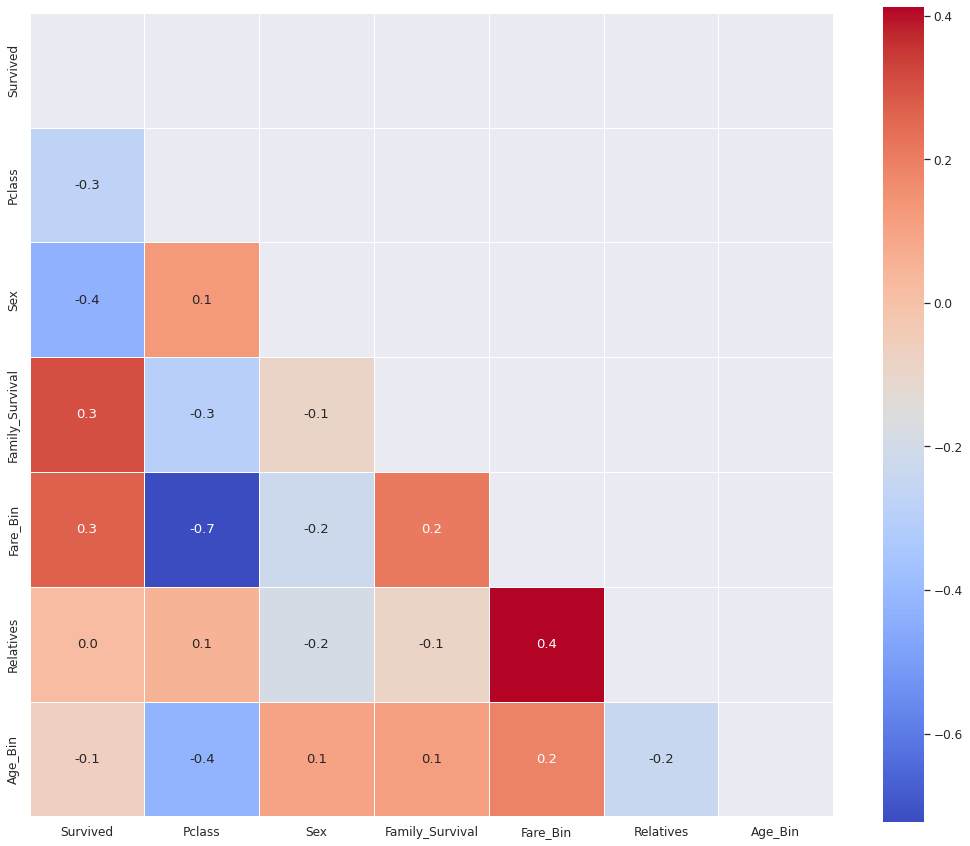

In [20]:
# Display numerical correlations between features on heatmap.

sns.set(font_scale=1.1)

corr = all_data.corr()
mask = np.triu(corr)

plt.figure(figsize=(18,15))

sns.heatmap(corr,
            annot=True,
            mask=mask,
            cmap='coolwarm',
            fmt='.1f',
            square=True,
            linewidth=1)
plt.show()

<a id="section14"></a>
# Modelling
Since preprocessing done we are ready for training our models. We start with loading packages and splitting our transformed data so we have 6 features and and 891 observations to train our estimators. Our test set has 418 observations to make predictions.


### [Back To Table of Contents](#toc_section)

In [21]:
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, KFold, learning_curve, train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve


from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [22]:
# split train test data

train = all_data[:891]

X_train = train.drop('Survived', 1)
y_train = train['Survived'].astype('int')


#######################################################

X_test = all_data[891:]

X_test.drop('Survived', axis = 1, inplace = True)

# Standardize data
std_scaler = StandardScaler()


X_train_scaled = std_scaler.fit_transform(X_train)  # fit_transform the X_train
X_test_scaled = std_scaler.transform(X_test)        # only transform the X_test

<a id="section15"></a>

# Baseline Models
The aim of this subsection is to calculate the baseline performance of 8 different estimators/classifiers on the training set. This will enable us to later see how tuning improves each of these models.

The classifiers are:

* Gaussian Naive Bayes ,
* Logistic Regression,
* K-Nearest Neighbor Classifier,
* Support Vector Classifier,
* Decision Tree Classifier,
* Random Forest Classifier,
* Xtreme Gradient Boosting Classifier, and
* AdaBoost classifier.

For the baseline models, we will use their default parameters and evaluate their (mean) accuracy by performing k-fold cross validation.

In [23]:
def model_check(X, y, estimators, cv=None):
    model_df = pd.DataFrame(columns = ['Model Name', 'Test Accuracy Mean', 'Train Accuracy Mean', 'Test Std', 'Time'])

    for row_index, clf in enumerate(estimators):

        cv_results = cross_validate(
            clf,
            X,
            y,
            cv=cv,
            scoring='accuracy',
            return_train_score=True,
            n_jobs=-1)

        model_df.loc[row_index] = [
            clf.__class__.__name__,
            cv_results['test_score'].mean(),
            cv_results['train_score'].mean(),
            cv_results['test_score'].std(),
            cv_results['fit_time'].mean()]
        
        #model_table.loc[row_index, 'clf Parameters'] = str(clf.get_params())

    model_df.sort_values(by=['Test Accuracy Mean'],
                            ascending=False,
                            inplace=True)
    # Accuracy score DataFrame
    display(model_df.style.background_gradient(cmap='summer_r'))
    
    # accuracy score graph
    sns.barplot('Test Accuracy Mean',
                'Model Name',
                data=model_df,
                orient='h',
                **{'xerr': model_df['Test Std']})
    plt.title('Cross Validation Scores')
    plt.xlim([0.725, 0.88])
    plt.show()

    #return model_df

,Model Name,Test Accuracy Mean,Train Accuracy Mean,Test Std,Time
5,XGBClassifier,0.857485,0.913020,0.013307,53.909139
6,LGBMClassifier,0.857473,0.902357,0.007426,0.086544
2,SVC,0.852947,0.863637,0.019758,0.121361
4,RandomForestClassifier,0.849645,0.914984,0.019549,0.274574
1,KNeighborsClassifier,0.849620,0.879628,0.016303,0.002782
3,DecisionTreeClassifier,0.848522,0.914984,0.017373,0.002647
7,AdaBoostClassifier,0.846275,0.914984,0.018319,0.148146
0,LogisticRegression,0.833902,0.840631,0.010279,0.008083
8,GaussianNB,0.781219,0.797137,0.046138,0.001592


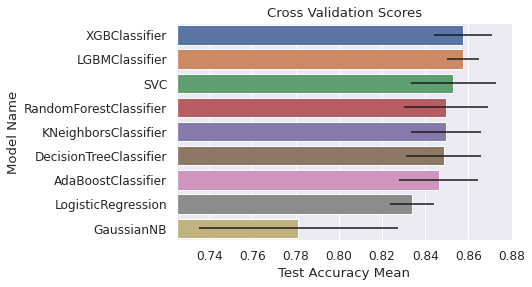

In [24]:
# Step 1: create a map containing all estimators with their default parameters
clf_list = [
    LogisticRegression(random_state = 1),
    KNeighborsClassifier(), 
    SVC(random_state = 1, probability = True),
    DecisionTreeClassifier(random_state = 1), 
    RandomForestClassifier(random_state = 1),
    XGBClassifier(random_state = 1, use_label_encoder=False),
    LGBMClassifier(),
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state = 1),
    GaussianNB()]

model_check(X=X_train_scaled, y= y_train, estimators= clf_list,cv=5)

All estimators have a score above 80%, with XGBClassifier & LGBMClassifier scoring the highest (85%).

<a id="section16"></a>

# Voting Classifier
We can combine the predictions of all these base classifiers and see if we get better predictive performance compared to each constituent individual classifier. This is the main motivation behind Ensemble Learning.

There are two options (see here and here):
* Hard Voting: A hard voting classifier counts the votes of each estimator in the ensemble and picks the class that gets the most votes. In other words, the majority wins.
* Soft Voting: Every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.

In [25]:
base_estimators = [(est.__class__.__name__, est) for est in clf_list]

for voting in ['soft', 'hard']:
    
    voting_classifier = VotingClassifier(
        estimators = base_estimators ,
        voting = voting)
    
    cv_results = cross_validate(
        voting_classifier,
        X_train_scaled,
        y_train,
        cv = 5,
        scoring='accuracy',
        return_train_score=True,
        n_jobs=-1)
    
    print(f'\n\n\n\nResult for {voting} VotingClassifier_______\n')
    display(pd.DataFrame(cv_results).mean())






Result for soft VotingClassifier_______



fit_time       55.798859
score_time      0.124592
test_score      0.859733
train_score     0.908810
dtype: float64





Result for hard VotingClassifier_______



fit_time       60.595744
score_time      0.161840
test_score      0.857492
train_score     0.909652
dtype: float64

<a id="section17"></a>
# Model Tuning
We are ready to tune hyperparameters using grid search and see if performance improves. For more information about hyperparemeters, please visit the corresponding documentation.

In [26]:
model_param = [
    (LogisticRegression(), {'max_iter' : [100],
                            'penalty' : ['l1', 'l2'],
                            'C' : np.logspace(-2, 2, 20),
                            'solver' : ['lbfgs', 'liblinear']}),
    (KNeighborsClassifier(), {'n_neighbors' : np.arange(3, 30, 1),
                              'weights': ['uniform', 'distance'],
                              'algorithm': ['auto'],
                              'p': [1, 2]}),
    (SVC(), [{'kernel': ['rbf'], 
              'gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5],
              'C': [0.1, 0.5,  1, 2, 5]},
              {'kernel': ['linear'], 
              'C': [.1, 1, 2, 10]},
              {'kernel': ['poly'], 
              'degree' : [2, 3, 4, 5], 
              'C': [.1, 1, 10]}]),
    #(DecisionTreeClassifier(random_state = 1), {'max_depth': [3, 5, 10, 20, 50],
    #                                            'criterion': ['entropy', 'gini'],
    #                                            'min_samples_split': [5, 10, 15, 30],
    #                                            'max_features': ['auto', 'sqrt', 'log2']}),
    (RandomForestClassifier(random_state = 42),{'n_estimators': [50, 150, 300, 450],
                                                'criterion': ['entropy'],
                                                'bootstrap': [True],
                                                'max_depth': [3, 5, 10],
                                                'max_features': ['auto','sqrt'],
                                                'min_samples_leaf': [2, 3],
                                                'min_samples_split': [2, 3]}),
    #(XGBClassifier(random_state = 1, use_label_encoder=False,tree_method='gpu_hist', gpu_id=0),{'n_estimators': [15, 25, 50, 100],
    #                                                                                            'colsample_bytree': [0.65, 0.75, 0.80],
    #                                                                                            #'max_depth': [None],
    #                                                                                            'reg_alpha': [1],
    #                                                                                            'reg_lambda': [1, 2, 5],
    #                                                                                            'subsample': [0.50, 0.75, 1.00],
    #                                                                                            'learning_rate': [0.01, 0.1, 0.5],
    #                                                                                            'gamma': [0.5, 1, 2, 5],
    #                                                                                            'min_child_weight': [0.01],
    #                                                                                            'sampling_method': ['uniform']}),
    (LGBMClassifier(random_state=42),{#'num_leaves': sp_randint(6, 50), 
                                      #'min_child_samples': sp_randint(100, 500), 
                                      'min_child_weight': [1e-5, 1e-1, 1, 1e1, 1e2, 1e4],
                                      #'subsample': sp_uniform(loc=0.2, scale=0.8), 
                                      #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                                      'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
                                      'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 10]}),
    (AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state=1),{'algorithm': ['SAMME', 'SAMME.R'],
                                                                                                    'base_estimator__criterion' : ['gini', 'entropy'],
                                                                                                    'base_estimator__splitter' : ['best', 'random'],
                                                                                                    'n_estimators': [2, 5, 10, 50],
                                                                                                    'learning_rate': [0.01, 0.1, 0.2, 0.3, 1, 2]})]


In [27]:
def model_tuning_check(X, y, estimators, cv=None):
    model_df = pd.DataFrame(columns = ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score','params','mean_fit_time'])
    best_estimators =[]
    
    for est, param in estimators:

        gscv = GridSearchCV(
            est,
            param_grid= param,
            scoring='accuracy',
            cv=cv,
            #refit=False,
            return_train_score=True,
            n_jobs=-1).fit(X,y)

        model_df.loc[est.__class__.__name__] = pd.DataFrame(
            gscv.cv_results_).loc[
            gscv.best_index_][['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score','params','mean_fit_time']]
        
        #save estimator for later use 
        best_estimators.append(gscv.best_estimator_)
        
    model_df.sort_values(by=['mean_test_score'],
                            ascending=False,
                            inplace=True)
    # Accuracy score DataFrame
    display(model_df.style.background_gradient(cmap='summer_r'))
    
    # accuracy score graph
    sns.barplot('mean_test_score',
                model_df.index,
                data=model_df,
                orient='h',
               **{'xerr': model_df['std_test_score']})
    plt.title('GridSearchCV Scores')
    plt.xlim([0.725, 0.88])
    plt.show()

    return best_estimators

,mean_test_score,mean_train_score,std_test_score,std_train_score,params,mean_fit_time
LGBMClassifier,0.866455,0.875422,0.012354,0.002967,"{'min_child_weight': 1e-05, 'reg_alpha': 1, 'reg_lambda': 5}",0.049289
KNeighborsClassifier,0.866449,0.869248,0.009561,0.002568,"{'algorithm': 'auto', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}",0.002050
SVC,0.864196,0.886082,0.004255,0.002751,"{'C': 10, 'degree': 4, 'kernel': 'poly'}",0.051035
RandomForestClassifier,0.861961,0.883278,0.013946,0.002700,"{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}",0.147102
AdaBoostClassifier,0.856387,0.914984,0.021685,0.002242,"{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.2, 'n_estimators': 50}",0.214792
LogisticRegression,0.847360,0.847643,0.004263,0.002291,"{'C': 0.026366508987303583, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.005414


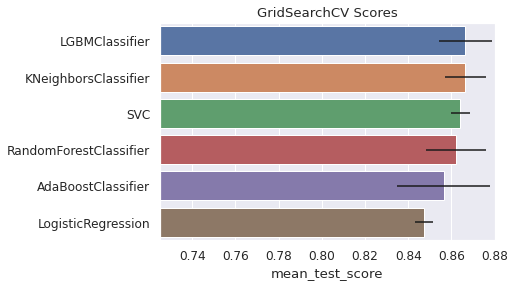

In [28]:
tuned_models= model_tuning_check(X_train_scaled, y_train, estimators= model_param)

We will now build the VotingClassfier ensembles:

In [29]:
model = VotingClassifier(
    estimators= [(clf.__class__.__name__, clf)  for clf in tuned_models],# if clf.__class__.__name__ not in ['AdaBoostClassifier', 'LogisticRegression']],
    voting='hard')

#model.fit(X_train_scaled, y_train)

result = cross_validate(model, 
               X_train_scaled,
               y_train,
               cv = 5,
               scoring='accuracy',
               return_train_score=True,
              n_jobs=-1)
print ('Tuned Voting classifier Models - \n-----------------------')
print (f'Accuracy => {np.round(result["test_score"].mean()*100, 2)} %')


Tuned Voting classifier Models - 
-----------------------
Accuracy => 86.87 %


<a id="section18"></a>
# ROC'S of the Models
Ok I'm going with the parts are that not much needed for this competition but I still want to apply them for the sake of learning and improving. Here are the results:

### [Back To Table of Contents](#toc_section)

In [30]:
def m_roc(estimators, cv, X, y):
    
    from scipy import interp
    from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc
    
    fig, axes = plt.subplots(3, 2, figsize=(25, 35))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i, (train, test) in enumerate(cv.split(X, y)):
            estimator.fit(X.loc[train], y.loc[train])
            viz = plot_roc_curve(estimator,
                                 X.loc[test],
                                 y.loc[test],
                                 name='ROC fold {}'.format(i),
                                 alpha=0.3,
                                 lw=1,
                                 ax=ax)
            interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1],
                linestyle='--',
                lw=2,
                color='r',
                label='Chance',
                alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr,
                mean_tpr,
                color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' %
                (mean_auc, std_auc),
                lw=2,
                alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr,
                        tprs_lower,
                        tprs_upper,
                        color='grey',
                        alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.02, 1.02],
               ylim=[-0.02, 1.02],
               title=f'{estimator.__class__.__name__} ROC')
        ax.legend(loc='lower right', prop={'size': 18})
    plt.show()

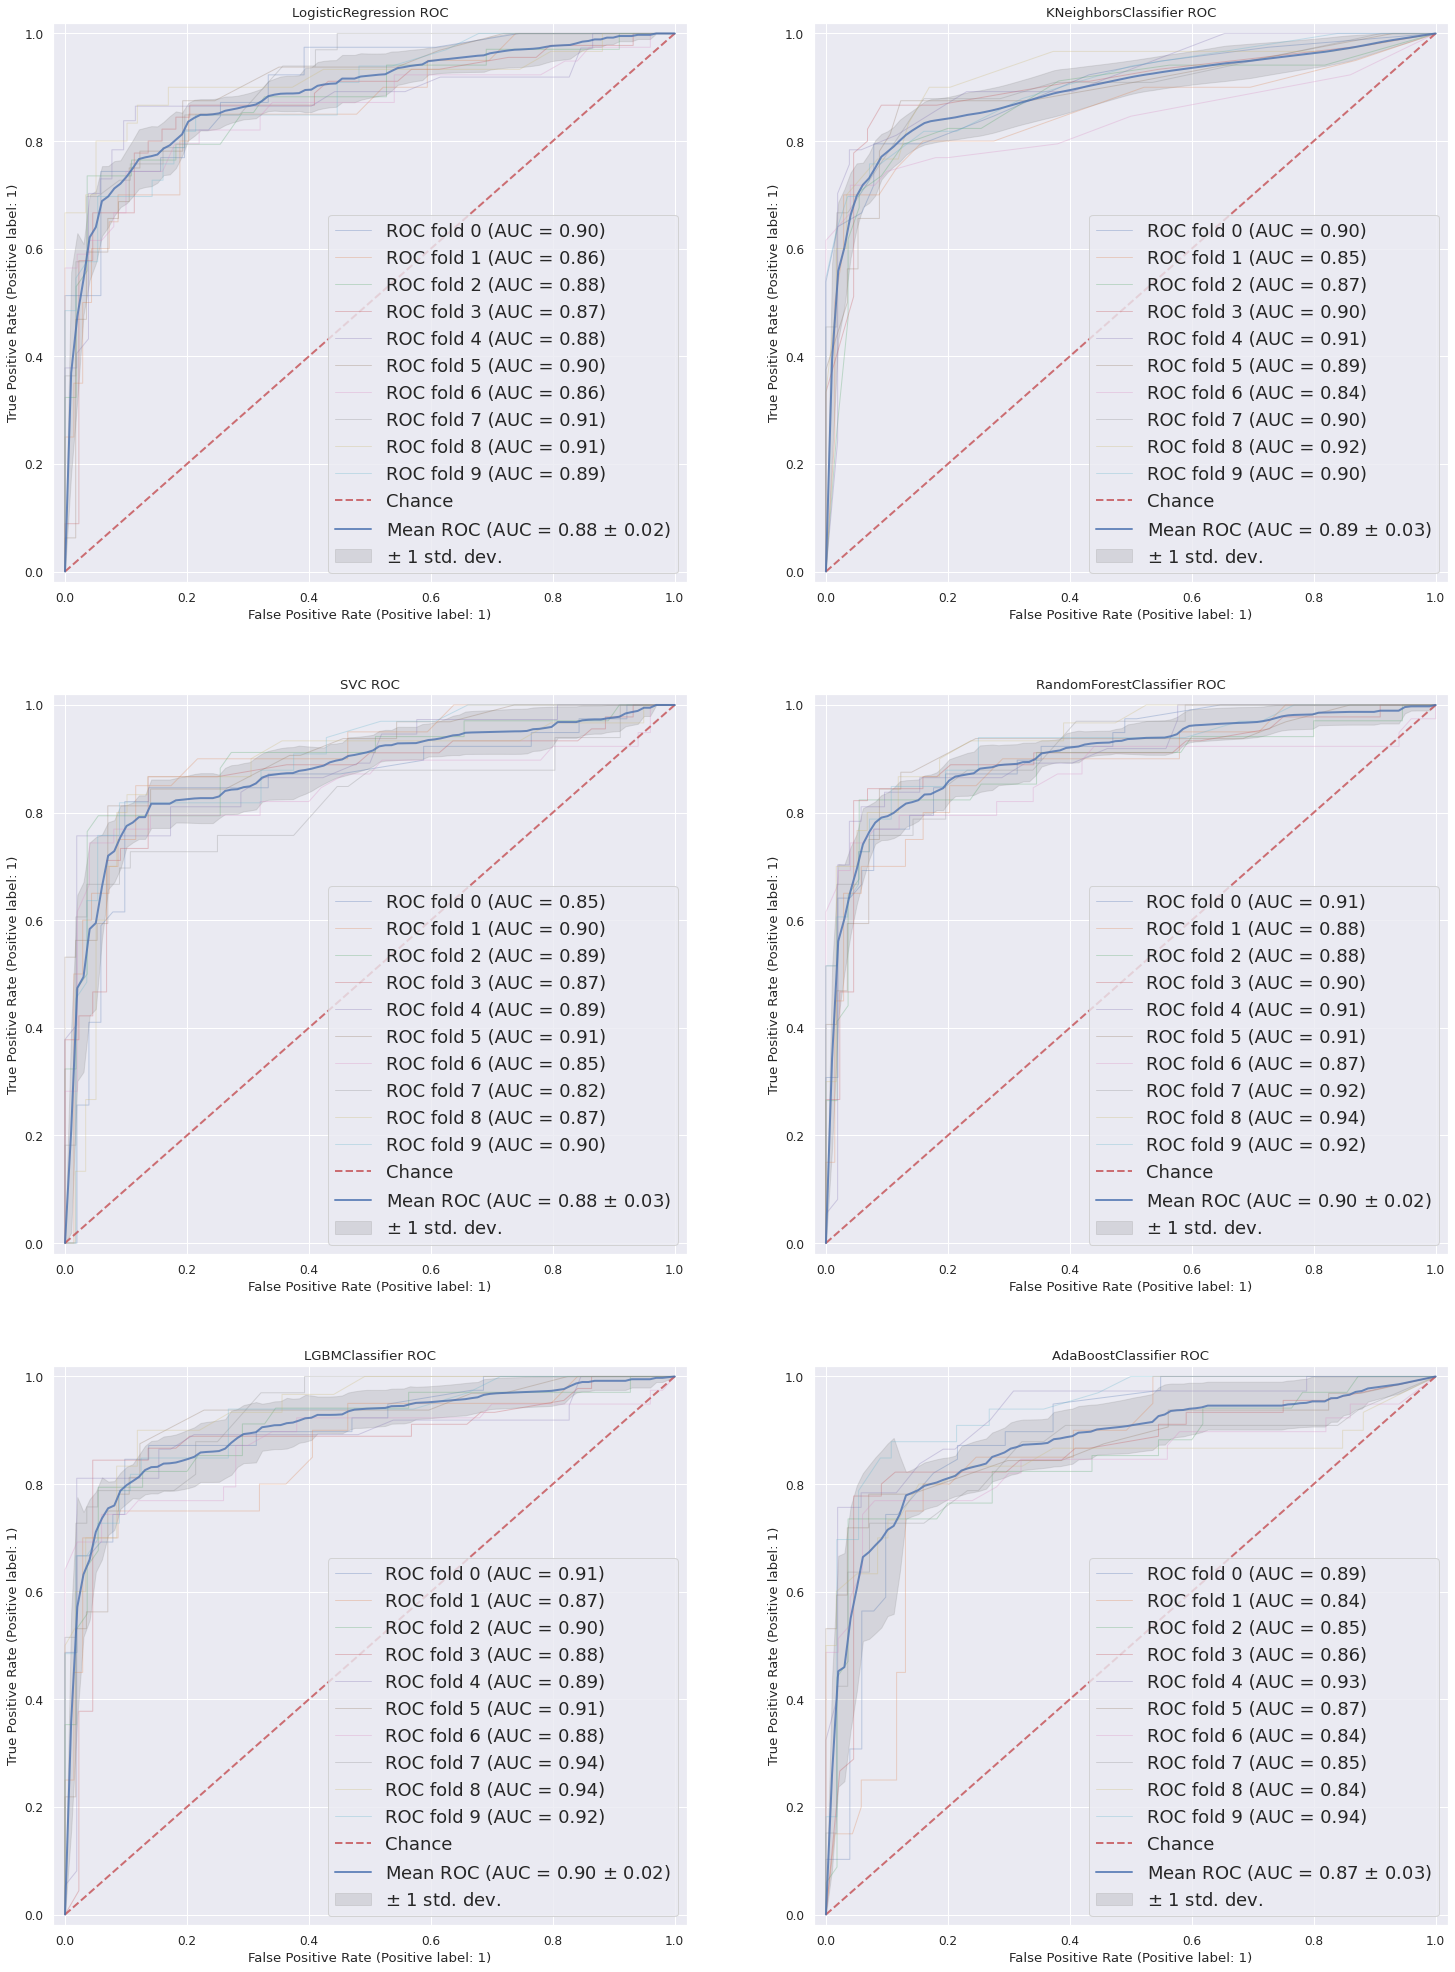

In [31]:
m_roc(tuned_models, KFold(10), pd.DataFrame(X_train_scaled), y_train)

<a id="section19"></a>
# Learning Curves of the Models
Learning curves are good indicators for showing if our models are overfitting or underfitting. It's also showing if we need more data or not but it's not the case here since we can't increase our numbers. After inspecting these graphs I'm thinking our top models are looking decent.

* The code below is edited version of this [example from sklearn official page.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py)

In [32]:
def plot_learning_curve(estimators,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    fig, axes = plt.subplots(3, 2, figsize=(25, 35))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):

        ax.set_title(f'{estimator.__class__.__name__} Learning Curve')
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='g')
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='r',
                label='Training score')
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='g',
                label='Cross-validation score')
        ax.legend(loc='best')
        
    plt.show()

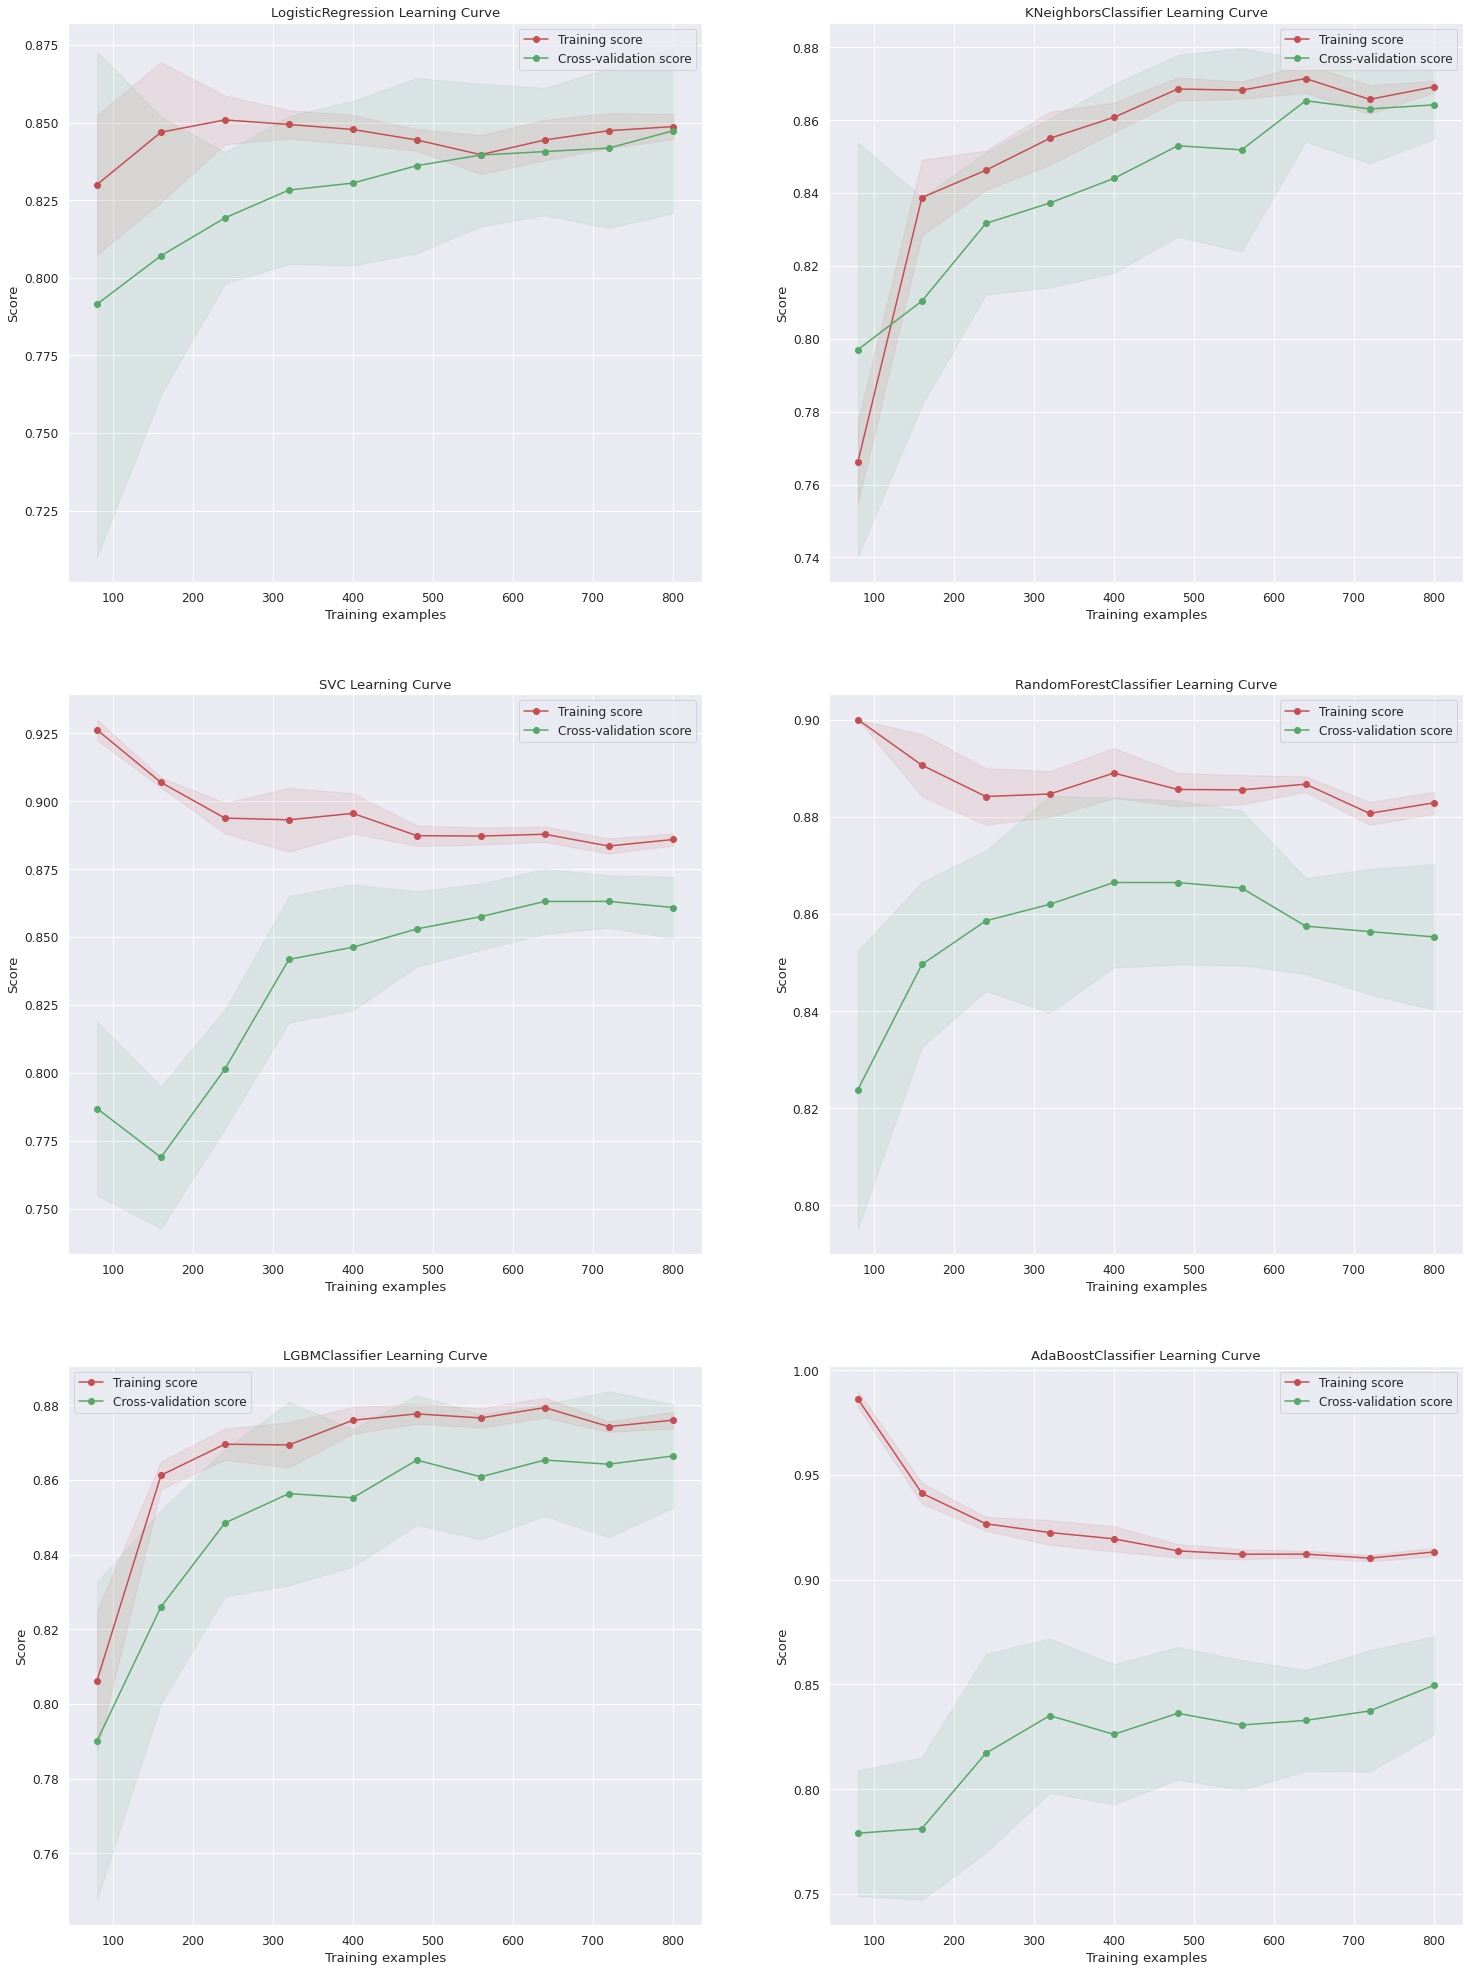

In [33]:
plot_learning_curve(tuned_models,
                    pd.DataFrame(X_train_scaled),
                    y_train,
                    ylim=None,
                    cv=KFold(10),
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))


# clean up memory
del tuned_models, model, clf_list, base_estimators, all_data, train, X_train, X_test, df

<a id="section20"></a>
# Dimensionality Reduction with Neighborhood Components Analysis
Neighborhood Components Analysis (NCA) tries to find a feature space such that a stochastic nearest neighbor algorithm will give the best accuracy. Like LDA, it is a supervised method.

Again with this we're reducing our models dimensions to 2, so we can plot decision regions.

### [Back To Table of Contents](#toc_section)

,mean_test_score,mean_train_score,std_test_score,std_train_score,params,mean_fit_time
KNeighborsClassifier,0.868715,0.869809,0.015443,0.002883,"{'algorithm': 'auto', 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}",0.001870
SVC,0.867591,0.882716,0.015859,0.003607,"{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}",0.026609
LGBMClassifier,0.867585,0.879351,0.016320,0.003608,"{'min_child_weight': 10.0, 'reg_alpha': 0, 'reg_lambda': 1}",0.033727
AdaBoostClassifier,0.864246,0.914984,0.021908,0.002242,"{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 50}",0.146359
RandomForestClassifier,0.863116,0.896184,0.019288,0.002493,"{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}",0.457684
LogisticRegression,0.824920,0.822672,0.012943,0.002832,"{'C': 0.11288378916846889, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}",0.002372


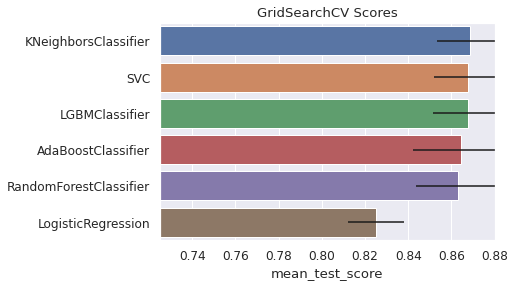

In [34]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

# PCA 
#X_train_pca= PCA(n_components=2).fit_transform(X_train_scaled)

# LinearDiscriminantAnalysis
#X_train_pca= LinearDiscriminantAnalysis(n_components=2).fit_transform(X_train_scaled, y_train)

# NeighborhoodComponentsAnalysis
NCA = NeighborhoodComponentsAnalysis(n_components=2).fit(X_train_scaled, y_train)

X_train_pca = NCA.transform(X_train_scaled)
X_test_pca =NCA.transform(X_test_scaled)

# memory cleanup
del NCA, X_train_scaled, X_test_scaled

# train models on X_train_pca
models_pca= model_tuning_check(X_train_pca, y_train, estimators= model_param)


<a id="section21"></a>

# Plotting Decision Boundaries
I just wanted to visualise how different models act on given 2D data. I can say that good fitting models produced similar results with small differences. I take this as a good theoretical information...

In [35]:
def dec_regs(X, y, estimators):
    from mlxtend.plotting import plot_decision_regions
    fig, axes = plt.subplots(3,2,figsize=(20, 30))

    axes = axes.flatten()
    
    for ax, estimator in zip(axes, estimators):
        estimator.fit(X, y.values)
        plot_decision_regions(X, y.values, clf=estimator,colors='#e00d14,#3ca02c',markers='x+', ax=ax)
        ax.set(title= estimator.__class__.__name__)

        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles,
                  ['Not Survived', 'Survived'],
                  framealpha=0.3, scatterpoints=1)

    plt.show()

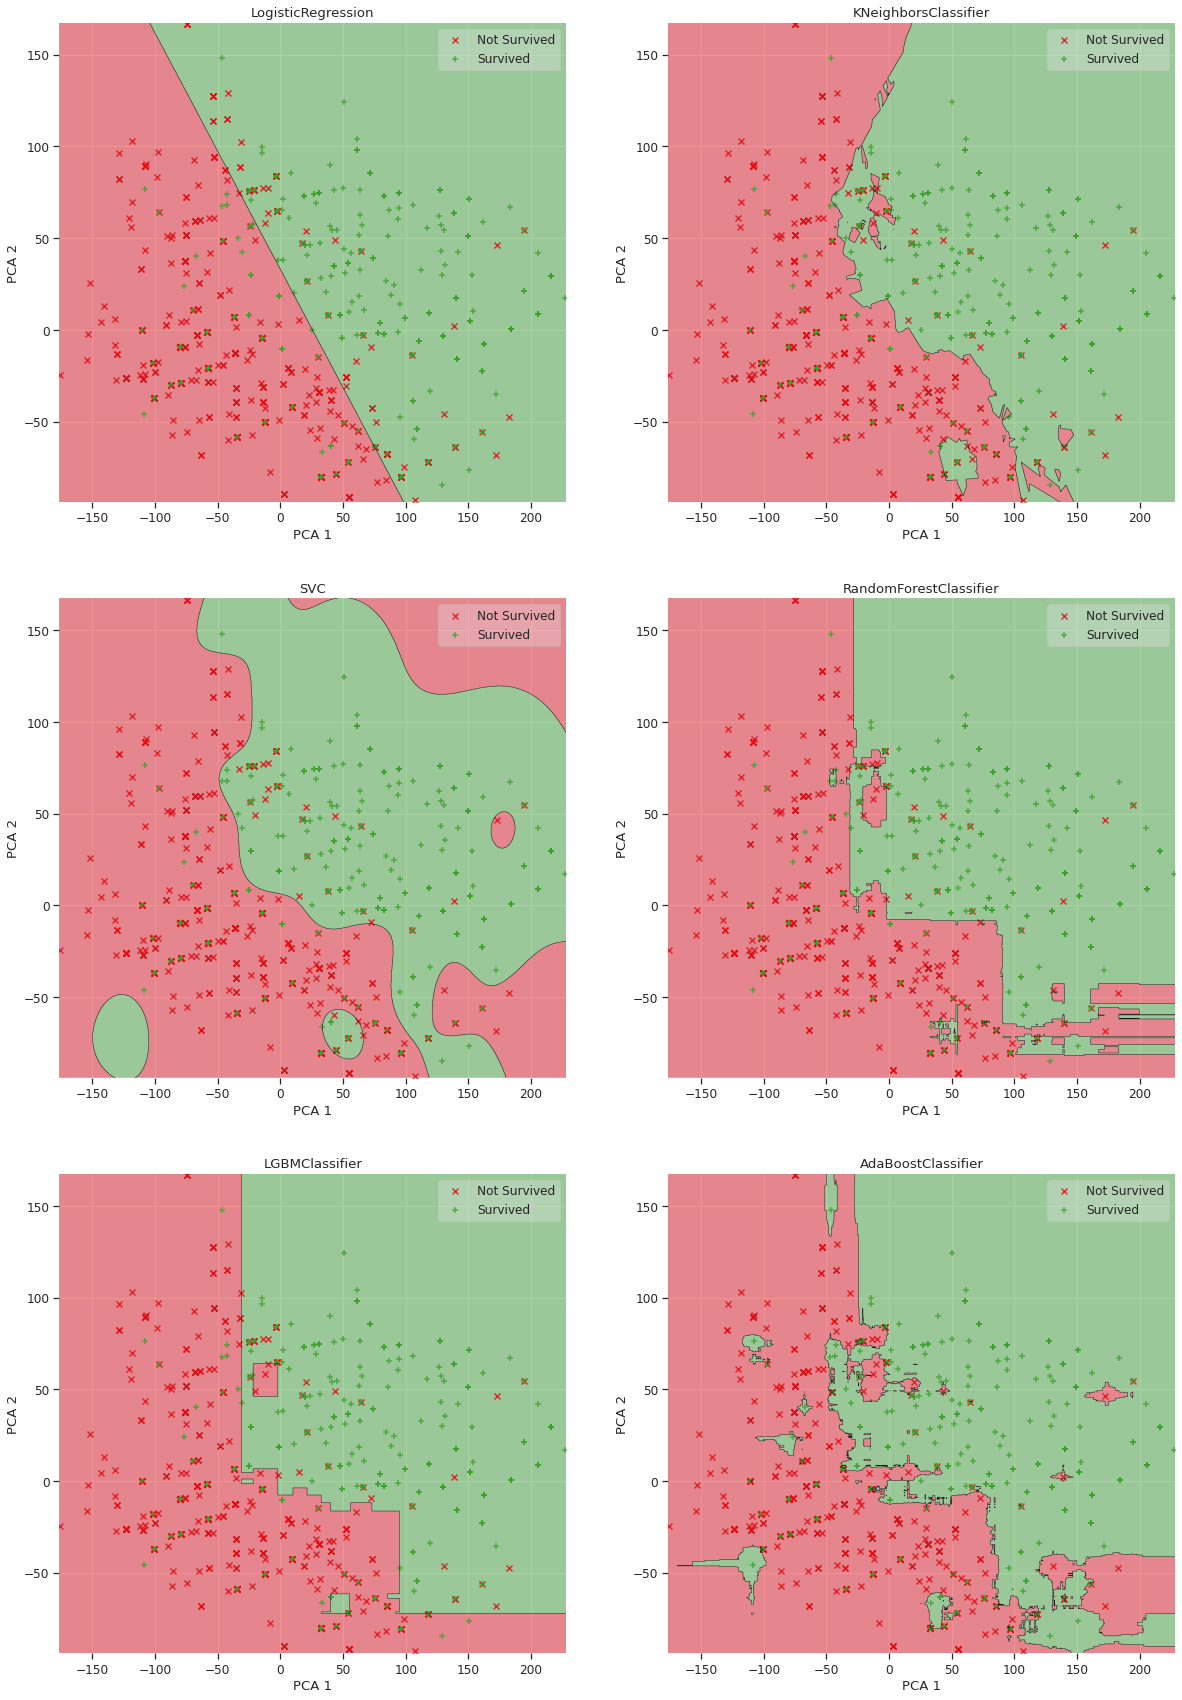

In [36]:
dec_regs(estimators=models_pca,
         X=X_train_pca,
         y=y_train)
                    

<a id="section22"></a>
# Plotting Decision Regions
Wanted to add this version including probabilities too,
We can see how sure are the models on deciding and also giving hints about how complex model is. This one still experimental for me and may need to be improved, I'd be grateful for your feedback!


* The code below is edited version of this [example from sklearn official page.](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-pyhttps://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)

In [37]:
def prob_regs(X, y, estimators):
    import math
    from matplotlib.colors import ListedColormap
    figure = plt.figure(figsize=(10, 10))
    h = .02
    i = 1

    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Just plot the dataset first
    cm = plt.cm.RdYlGn
    cm_bright = ListedColormap(['#e00d14', '#3ca02c'])
    ax = plt.subplot(5, 2, i)

    # Iterate over estimators
    for clf in estimators:
        ax = plt.subplot(math.ceil(len(estimators) / 2), 2, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        g = ax.scatter(X_train[:, 0],
                       X_train[:, 1],
                       c=y_train,
                       cmap=cm_bright,
                       edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c=y_test,
                   cmap=cm_bright,
                   edgecolors='k',
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

        ax.set_title(clf.__class__.__name__)
        #ax.text(xx.max() - .3,
        #        yy.min() + .3, (f'Score:{score:.2f}'),
        #        size=15,
        #        horizontalalignment='right')

        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')
        plt.legend(handles=g.legend_elements()[0],
                   labels=['Not Survived', 'Survived'],
                   framealpha=0.3,
                   scatterpoints=1)

        i += 1

    plt.tight_layout()
    plt.show()

In [38]:
#prob_regs(X_train_pca, y_train, models_pca)


<a id="section23"></a>
# Submission


### [Back To Table of Contents](#toc_section)

In [39]:
model_pca_vc = VotingClassifier(
    estimators= [(clf.__class__.__name__, clf)  for clf in models_pca],# if clf.__class__.__name__ not in ['AdaBoostClassifier', 'LogisticRegression']],
    voting='hard')

model_pca_vc.fit(X_train_pca, y_train)

result = cross_validate(model_pca_vc, 
               X_train_pca,
               y_train,
               cv = 5,
               scoring='accuracy',
               return_train_score=True,
              n_jobs=-1)
print ('Tuned Voting classifier Models on dimentionaly reduced dataset - \n-----------------------')
print (f'Accuracy => {np.round(result["test_score"].mean()*100, 2)} %')


Tuned Voting classifier Models on dimentionaly reduced dataset - 
-----------------------
Accuracy => 86.2 %


In [40]:
y_pred = model_pca_vc.predict(X_test_pca)

test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test_df['PassengerId']
submission_df['Survived'] = y_pred
submission_df.to_csv('submission.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
